# Visualizing Perturbations

TJ Kim

1.7.22

#### Summary:
- Perform attacks on a specific data point with L2 and Linf attacks
- Visualize image with perturbations of varying degrees
- Goal is to show the limit of perturbation amount before obvious to human eye 

In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


#### Import Relevant Libaries

In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

### Generate Aggregator Pre-requisite
- Clients, Test Clients, Ensemble_Learner
- Follow through the code in run_experiment.py

In [3]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = "FedEM"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/21_12_30_feddef2_n40_linf0_5/'
args_.validation = False

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 195.40it/s]


===> Initializing clients..


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.61it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.195% |Test Loss: 2.292 | Test Acc: 12.291% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


#### Generate Data

In [4]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

#### Load Specific Model

In [5]:
# Change name if need be
args_.save_path = 'weights/cifar/21_12_30_feddef_n40_linf0_5/'

# Import weights for aggregator
aggregator.load_state(args_.save_path)

# This is where the models are stored -- one for each mixture --> learner.model for nn
hypotheses = aggregator.global_learners_ensemble.learners

# obtain the state dict for each of the weights 
weights_h = []

for h in hypotheses:
    weights_h += [h.model.state_dict()]
    
weight_name = args_.save_path + 'train_client_weights.npy'
weights = np.load(weight_name)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

#print(weights)

# Set model weights
model_weights = []
num_models = 40

for i in range(num_models):
    model_weights += [weights[i]]
    
    
# Generate the weights to test on as linear combinations of the model_weights
models_test = []

for (w0,w1,w2) in model_weights:
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    new_model.eval()
    new_weight_dict = copy.deepcopy(weights_h[0])
    for key in weights_h[0]:
        new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
    new_model.load_state_dict(new_weight_dict)
    models_test += [new_model]

#### Generate Transferer and Obtain Image for Perturbation

In [54]:
# Perform Attack
a1 = Adv_NN(models_test[0], dataloader)

# Select data point - not same as target label
target = 5
item_flag = True
while item_flag:
    data_x, data_y = a1.dataloader.load_batch(batch_size=1, mode='test')
    if data_y != target:
        item_flag = False

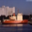

In [55]:
# Print image - original
img1 = unnormalize_cifar10(data_x).cpu()
img1 = img1.transpose(2,3)
img1 = img1.transpose(3,0)
img1 = img1[0]
img = Image.fromarray(img1.numpy())
display(img)

#### Loop through Linf norms and print images

L2 ep: 0.05


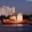

L2 ep: 0.1


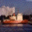

L2 ep: 0.2


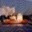

L2 ep: 0.4


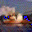

In [62]:
L2_eps = [0.05, 0.1, 0.2, 0.4]

for i in range(len(L2_eps)):

    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 30,
                   target = target, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.05, step_norm = "inf", eps = L2_eps[i], eps_norm = "inf")

    a1.pgd_sub(atk_params, data_x, data_y)
    
    nx = a1.x_adv
    
    img1 = unnormalize_cifar10(nx).cpu()
    img1 = img1.transpose(2,3)
    img1 = img1.transpose(3,0)
    img1 = img1[0]
    img = Image.fromarray(img1.numpy())
    print("L2 ep:", L2_eps[i])
    display(img)

L2 ep: 0.05


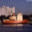

L2 ep: 0.1


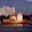

L2 ep: 0.2


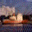

L2 ep: 0.4


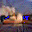

In [63]:
L2_eps = [0.05, 0.1, 0.2, 0.4]

for i in range(len(L2_eps)):

    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 30,
                   target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.05, step_norm = "inf", eps = L2_eps[i], eps_norm = "inf")

    a1.pgd_sub(atk_params, data_x, data_y)
    
    nx = a1.x_adv
    
    img1 = unnormalize_cifar10(nx).cpu()
    img1 = img1.transpose(2,3)
    img1 = img1.transpose(3,0)
    img1 = img1[0]
    img = Image.fromarray(img1.numpy())
    print("L2 ep:", L2_eps[i])
    display(img)